<a href="https://colab.research.google.com/github/ziatdinovmax/gpax/blob/main/examples/GP_sGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For github continuous integration
import os
if os.environ.get("CI_SMOKE"):
    NUM_WARMUP = 10
    NUM_SAMPLES = 10
else:
    NUM_WARMUP = 2000
    NUM_SAMPLES = 2000

# Structured Gaussian Process

This notebook compares vanilla and structured Gaussian processes for reconstructing and active learning of function characterized by a discontinuous behavior at some "transition" point.

*Prepared by Maxim Ziatdinov (2022). Last updated in October 2023.*

In the previous [example](https://colab.research.google.com/github/ziatdinovmax/gpax/blob/main/examples/simpleGP.ipynb), we have introduced Gaussian process (GP) operating in a fully Bayesian mode for reconstucting, with quantified uncertainty, an unknown function from sparse measurements. The limitation of the standard GP is that it does not usually allow for the incorporation of prior domain knowledge and can be biased toward a trivial interpolative solution. Recently, we introduced a structured Gaussian Process (sGP), where a classical GP is augmented by a structured probabilistic model of the expected system’s behavior. This approach allows us to balance the flexibility of the non-parametric GP approach with a rigid structure of prior (physical) knowledge encoded into the parametric model. Implementation-wise, this is achieved by substituting a zero prior mean function in GP with a probabilistic model of the expected system's behavior.

## Install & Import

Install the latest GPax package from PyPI (this is best practice, as it installs the latest, deployed and tested version).

In [2]:
!pip install -q gpax

Import needed packages:

In [3]:
try:
    # For use on Google Colab
    import gpax

except ImportError:
    # For use locally (where you're using the local version of gpax)
    print("Assuming notebook is being run locally, attempting to import local gpax module")
    import sys
    sys.path.append("..")
    import gpax

In [4]:
import numpy as np
import matplotlib.pyplot as plt

gpax.utils.enable_x64()  # enable double precision

Enable some pretty plotting.

In [5]:
import matplotlib as mpl

In [6]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.usetex'] = False
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
mpl.rcParams['figure.dpi'] = 200

## Standard and structured GP

We consider noisy observations of a discontinuous function...

In [7]:
def piecewise1(x: np.ndarray, params) -> np.ndarray:
    return np.piecewise(
        x,
        [x < params["t"], x >= params["t"]],
        [lambda x: x**params["beta1"], lambda x: x**params["beta2"]])


NUM_INIT_POINTS = 15 # number of observation points
NOISE_LEVEL = 0.1
PARAMS = {"t": 1.7, "beta1": 4.5, "beta2": 2.5}

np.random.seed(1)
X = np.random.uniform(0, 3, NUM_INIT_POINTS)
y = piecewise1(X, PARAMS) + np.random.normal(0., NOISE_LEVEL, NUM_INIT_POINTS)

X_test = np.linspace(0, 3, 200)


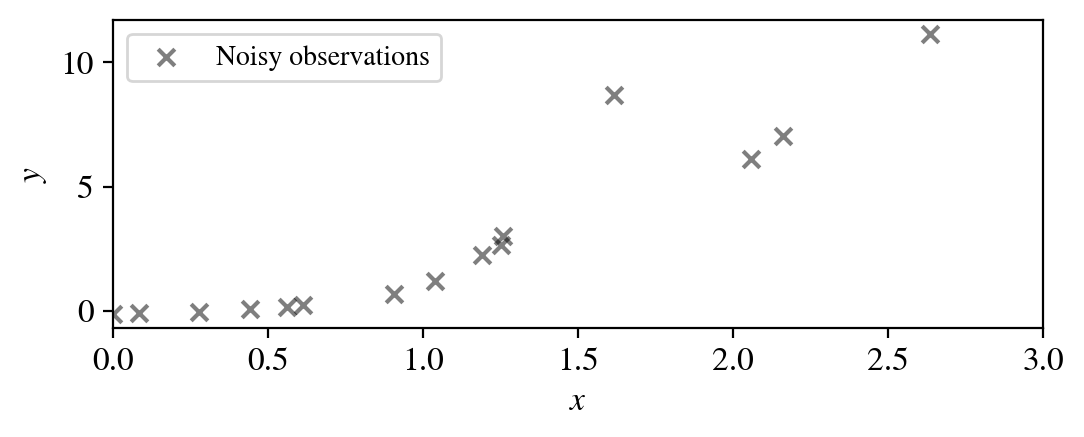

In [8]:
_, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.scatter(X, y, alpha=0.5, c='k', marker='x', label="Noisy observations")
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_xlim(0, 3)

plt.show()

... and try to reconstruct this underlying function with a standard GP

In [9]:
# Get random number generator keys (see JAX documentation for why it is neccessary)
rng_key, rng_keposterior_meanict = gpax.utils.get_keys()

# Initialize model
gp_model = gpax.ExactGP(1, kernel='Matern')

# Run HMC to obtain posterior samples
gp_model.fit(rng_key, X, y, num_chains=1)

# Get GP prediction
posterior_mean, f_samples = gp_model.predict(rng_keposterior_meanict, X_test, n=200)

sample: 100%|██████████| 4000/4000 [00:13<00:00, 299.14it/s, 7 steps of size 6.22e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.61      0.17      0.58      0.40      0.80    549.76      1.00
    k_scale     19.08      9.91     16.54      7.12     31.91    915.50      1.00
      noise      0.28      0.39      0.17      0.01      0.58    555.31      1.00



Plot the results

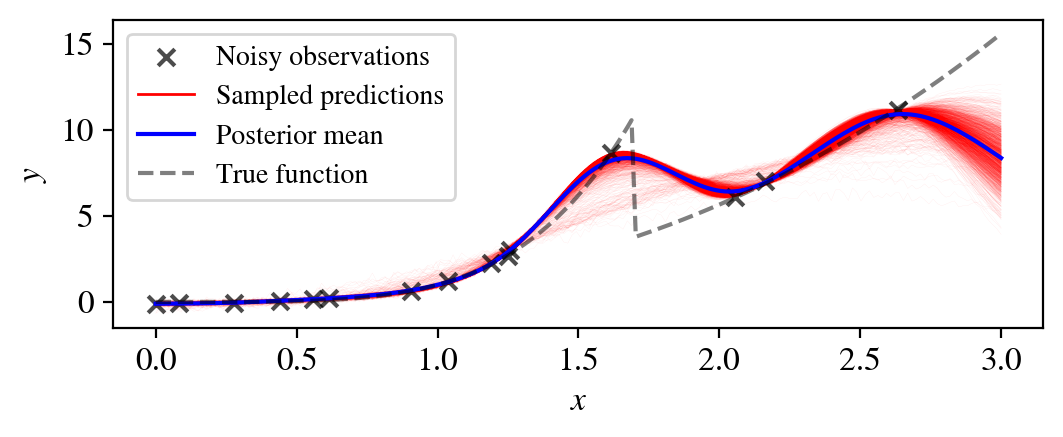

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, y, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
for y1 in f_samples:
    ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
l, = ax.plot(X_test, f_samples[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_test, posterior_mean, lw=1.5, zorder=1, c='b', label='Posterior mean')
ax.plot(X_test, piecewise1(X_test, PARAMS), c='k', linestyle='--', label='True function', alpha=0.5)
ax.legend(loc='upper left')
l.set_alpha(0)

The standard GP did not perform very well. Now let's try GP augmented by a probabilistic models of *expected* system's behavior. We'l need to use JAX's version of numpy for defining operations on arrays and NumPyro for placing priors over model parameters:

In [11]:
from typing import Dict

import numpyro
import jax.numpy as jnp

Define possible models as deterministic functions. Notice that the first model has a correct 'guess' about the underlying function. The second model is only partially correct (it assumes the existence of transition point, but describe the behavior before and after that point as linear).

In [12]:
def piecewise1(x: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:
    """Power-law behavior before and after the transition"""
    return jnp.piecewise(
        x, [x < params["t"], x >= params["t"]],
        [lambda x: x**params["beta1"], lambda x: x**params["beta2"]])

def piecewise2(x: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:
    """Linear behavior before and after the transition"""
    return jnp.piecewise(
        x, [x < params["t"], x >= params["t"]],
        [lambda x: params["b"]*x, lambda x: params["c"]*x])

Put priors over parameters of each model (to make them probabilistic):

In [13]:
def piecewise1_priors():
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(0.5, 2.5))
    beta1 = numpyro.sample("beta1", numpyro.distributions.LogNormal(0, 1))
    beta2 = numpyro.sample("beta2", numpyro.distributions.LogNormal(0, 1))
    # Return sampled parameters as a dictionary
    return {"t": t, "beta1": beta1, "beta2": beta2}


def piecewise2_priors():
    # Sample model parameters
    t = numpyro.sample("t", numpyro.distributions.Uniform(0.5, 2.5))
    b = numpyro.sample("b", numpyro.distributions.LogNormal(0, 1))
    c = numpyro.sample("c", numpyro.distributions.LogNormal(0, 1))
    # Return sampled parameters as a dictionary
    return {"t": t, "b": b, "c": c}

Run a 'structured' GP (*s*GP) for each model. Note that to make our GP 'structured', we pass the ```mean_fn``` (deterministic function) and ```mean_fn_prior``` (priors over the function parameters) arguments to it at the initialization stage.

sample: 100%|██████████| 4000/4000 [00:12<00:00, 310.16it/s, 80 steps of size 4.14e-02. acc. prob=0.86]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      4.46      0.06      4.47      4.38      4.56    417.39      1.00
      beta2      2.47      0.04      2.48      2.41      2.54    300.77      1.00
k_length[0]      3.56      2.65      2.83      0.33      6.91    540.74      1.00
    k_scale      0.58      0.62      0.36      0.03      1.33    408.26      1.00
      noise      0.03      0.03      0.03      0.00      0.06    398.94      1.00
          t      1.83      0.13      1.83      1.62      2.02    345.14      1.00



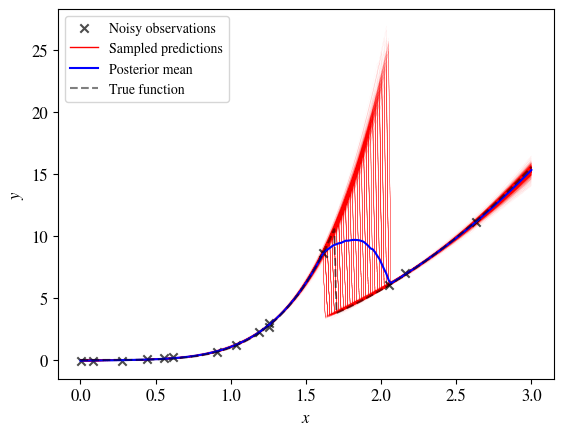

sample: 100%|██████████| 4000/4000 [01:21<00:00, 49.27it/s, 1023 steps of size 2.37e-03. acc. prob=0.81]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      0.99      0.63      0.88      0.09      1.91    573.45      1.00
          c      4.01      0.47      4.00      3.23      4.72    406.63      1.00
k_length[0]      0.39      0.13      0.38      0.18      0.57    236.03      1.00
    k_scale      2.25      1.45      1.88      0.51      4.15    343.52      1.01
      noise      0.20      0.21      0.14      0.01      0.40    332.27      1.01
          t      1.43      0.11      1.43      1.26      1.58    296.27      1.00



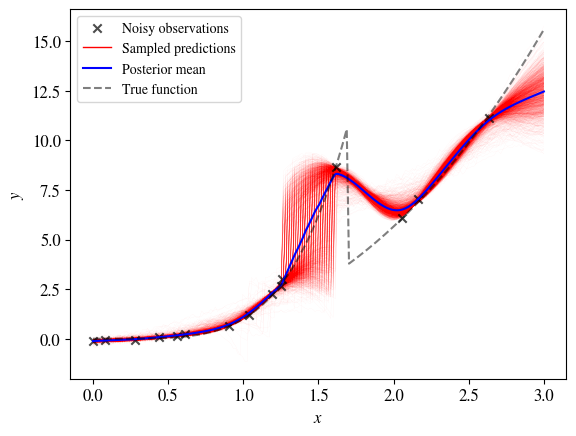

In [14]:
mean_fn = [piecewise1, piecewise2]
mean_fn_priors = [piecewise1_priors, piecewise2_priors]

for m, mp in zip(mean_fn, mean_fn_priors):

    # Initialize model
    gp_model = gpax.ExactGP(1, kernel='Matern', mean_fn=m, mean_fn_prior=mp)

    # Run MCMC to obtain posterior samples
    gp_model.fit(rng_key, X, y, num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES)

    # Get GP prediction
    posterior_mean, f_samples = gp_model.predict(rng_keposterior_meanict, X_test, n=200)

    # Plot results
    _, ax = plt.subplots(dpi=100)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.scatter(X, y, marker='x', c='k', zorder=1, label="Noisy observations", alpha=0.7)
    for y1 in f_samples:
        ax.plot(X_test, y1.mean(0), lw=.1, zorder=0, c='r', alpha=.1)
    l, = ax.plot(X_test, f_samples[0].mean(0), lw=1, c='r', alpha=1, label="Sampled predictions")
    ax.plot(X_test, posterior_mean, lw=1.5, zorder=1, c='b', label='Posterior mean')
    ax.plot(X_test, piecewise1(X_test, PARAMS), c='k', linestyle='--', label='True function', alpha=0.5)
    ax.legend(loc='upper left')
    l.set_alpha(0)
    plt.show()

We can see that the first *s*GP model performed exceptionally well, except for the transition region where we do not have enough observations. However, this region is also characterized by very large uncertainty (variation in the sampled predictions), suggesting that one may want to perform extra measurements in that area. For the second *s*GP model, the reconstruction quality is much lower, even though it is still somewhat better than for vanilla GP. This is not surprising because the second model is much less acccurate (it assumes linear behavior before and after the transition point, which is obviously not the case here)

## Simple active learning with structured GP

We can further explore regions with high uncertainty using the active learning approach. In this approach, the next evaluation point is selected according to $$x_{next}=\arg \max_x𝜎[f_*]$$

where $𝜎$ is the uncertainty in prediction of function $f_*$ over the parameter range $x$. First, we are going to use the model that produced the lowest total uncertainty on the original set of observations.

In [15]:
# Copy the initial observations so that we can re-use them later
Xo, yo = X.copy(), y.copy()

In [16]:
rng_key, rng_keposterior_meanict = gpax.utils.get_keys(1)

for i in range(6):
    print("\nExploration step {}".format(i+1))
    # Obtain/update GP posterior
    gp_model = gpax.ExactGP(1, kernel='Matern', mean_fn=piecewise1, mean_fn_prior=piecewise1_priors)
    gp_model.fit(rng_key, X, y, print_summary=1, num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES)
    # Compute acquisition function (here it is simply the uncertinty in prediciton)
    # and get the coordinate of the next point to measure
    obj = gpax.acquisition.UE(rng_keposterior_meanict, gp_model, X_test)
    next_point_idx = obj.argmax()
     # Append the 'suggested' point
    X = np.append(X, X_test[next_point_idx])
    measured = piecewise1(X_test[next_point_idx], PARAMS) + np.random.normal(0., NOISE_LEVEL)  # we assume that new observations are also noisy
    y = np.append(y, measured)



Exploration step 1


sample: 100%|██████████| 4000/4000 [00:10<00:00, 381.85it/s, 31 steps of size 1.23e-01. acc. prob=0.83]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      4.46      0.06      4.46      4.36      4.56    450.20      1.02
      beta2      2.48      0.04      2.48      2.40      2.54    505.79      1.00
k_length[0]      3.89      4.27      2.73      0.25      7.45    517.83      1.00
    k_scale      0.61      0.73      0.39      0.02      1.26    738.84      1.00
      noise      0.03      0.03      0.03      0.01      0.07    471.75      1.00
          t      1.82      0.13      1.82      1.62      2.01    363.59      1.02


Exploration step 2


sample: 100%|██████████| 4000/4000 [00:08<00:00, 463.50it/s, 31 steps of size 1.35e-01. acc. prob=0.84]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      4.46      0.05      4.46      4.38      4.55    470.60      1.00
      beta2      2.47      0.04      2.48      2.41      2.53    358.39      1.00
k_length[0]      3.82      3.40      2.91      0.31      7.15    536.54      1.00
    k_scale      0.60      0.73      0.38      0.02      1.28    576.45      1.00
      noise      0.03      0.02      0.02      0.01      0.05    468.55      1.00
          t      1.77      0.09      1.77      1.62      1.90    245.65      1.01


Exploration step 3


sample: 100%|██████████| 4000/4000 [00:10<00:00, 381.33it/s, 1 steps of size 2.40e-01. acc. prob=0.79] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      4.47      0.05      4.47      4.40      4.54    548.60      1.01
      beta2      2.48      0.03      2.48      2.43      2.53    488.87      1.00
k_length[0]      4.11      3.37      3.11      0.25      8.36    420.28      1.00
    k_scale      0.61      0.77      0.37      0.03      1.36    496.66      1.00
      noise      0.02      0.02      0.02      0.01      0.05    677.25      1.00
          t      1.71      0.06      1.71      1.62      1.81    404.94      1.00


Exploration step 4


sample: 100%|██████████| 4000/4000 [00:10<00:00, 372.29it/s, 2 steps of size 3.22e-01. acc. prob=0.74] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      4.47      0.05      4.47      4.40      4.54    458.85      1.00
      beta2      2.48      0.04      2.48      2.43      2.54    397.51      1.00
k_length[0]      4.08      3.66      3.01      0.58      8.07    523.68      1.00
    k_scale      0.59      0.76      0.36      0.02      1.33    552.74      1.00
      noise      0.02      0.01      0.02      0.01      0.04    533.67      1.00
          t      1.68      0.04      1.68      1.62      1.74    330.66      1.00


Exploration step 5


sample: 100%|██████████| 4000/4000 [00:12<00:00, 332.53it/s, 4 steps of size 3.21e-01. acc. prob=0.76]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      4.49      0.03      4.49      4.44      4.53    430.12      1.01
      beta2      2.48      0.04      2.48      2.42      2.54    355.51      1.00
k_length[0]      3.91      3.35      3.01      0.51      7.79    461.38      1.00
    k_scale      0.55      0.60      0.36      0.02      1.12    722.16      1.00
      noise      0.02      0.01      0.02      0.01      0.04    643.14      1.00
          t      1.72      0.02      1.72      1.69      1.74    247.81      1.00


Exploration step 6


sample: 100%|██████████| 4000/4000 [00:12<00:00, 323.56it/s, 1 steps of size 3.30e-01. acc. prob=0.75] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      4.49      0.03      4.49      4.44      4.53    400.75      1.02
      beta2      2.48      0.04      2.48      2.43      2.54    306.79      1.01
k_length[0]      4.15      3.82      3.05      0.45      8.16    510.27      1.00
    k_scale      0.60      0.77      0.37      0.02      1.23    618.53      1.00
      noise      0.02      0.01      0.02      0.01      0.03    551.47      1.00
          t      1.70      0.01      1.70      1.69      1.71    301.08      1.00



Make the prediction using all the newly discovered points:

In [17]:
rng_key, rng_keposterior_meanict = gpax.utils.get_keys(1)
# Update GP posterior
gp_model = gpax.ExactGP(1, kernel='Matern', mean_fn=piecewise1, mean_fn_prior=piecewise1_priors)
gp_model.fit(rng_key, X, y)
# Get GP prediction
posterior_mean, f_samples = gp_model.predict(rng_keposterior_meanict, X_test, n=200)

sample: 100%|██████████| 4000/4000 [00:14<00:00, 273.31it/s, 1 steps of size 2.82e-01. acc. prob=0.79] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta1      4.50      0.03      4.50      4.45      4.54    347.86      1.00
      beta2      2.48      0.04      2.48      2.42      2.54    197.01      1.00
k_length[0]      3.85      3.68      2.76      0.58      7.71    487.08      1.00
    k_scale      0.62      0.72      0.38      0.02      1.46    523.37      1.00
      noise      0.02      0.01      0.02      0.01      0.03    593.62      1.00
          t      1.70      0.00      1.69      1.69      1.70    219.34      1.00



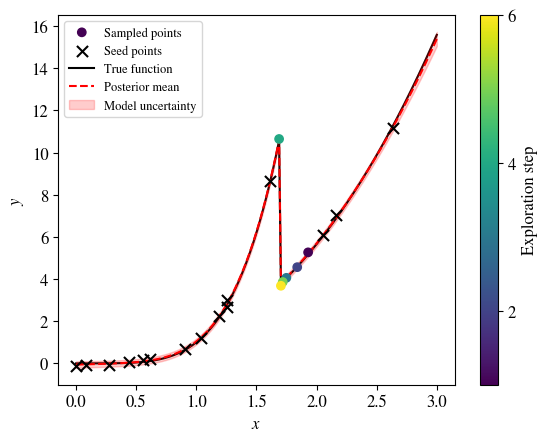

In [18]:
# Plot results
truefunc = piecewise1(X_test, PARAMS)
seed_points = 15
plt.figure(dpi=100)
plt.scatter(X[seed_points:], y[seed_points:], c=jnp.arange(1, len(X[seed_points:])+1),
            cmap='viridis', label="Sampled points", zorder=1)
cbar = plt.colorbar(label="Exploration step")
cbar_ticks = np.arange(2, len(X[seed_points:]) + 1, 2)
cbar.set_ticks(cbar_ticks)
plt.scatter(X[:seed_points], y[:seed_points], marker='x', s=64,
            c='k', label="Seed points", zorder=1)
plt.plot(X_test, truefunc, c='k', label='True function', zorder=0)
plt.plot(X_test, posterior_mean, '--', c='red', label='Posterior mean', zorder=0)

plt.fill_between(X_test, posterior_mean - f_samples.std((0,1)), posterior_mean + f_samples.std((0,1)),
                        color='r', alpha=0.2, label="Model uncertainty", zorder=0)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", fontsize=12)
plt.legend(fontsize=9)
plt.show()

Now we are going do active learning with the 'wrong' (or partially correct, depending on whether you are pessimist or optimist) model. We will start from the same set of observations as before.

In [19]:
X, y = Xo, yo  # start from the same set of observations

rng_key, rng_keposterior_meanict = gpax.utils.get_keys(1)

for i in range(9):
    print("\nExploration step {}".format(i+1))
    # Obtain/update GP posterior
    gp_model = gpax.ExactGP(1, kernel='Matern', mean_fn=piecewise2, mean_fn_prior=piecewise2_priors)
    gp_model.fit(rng_key, X, y, print_summary=1, num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES)
    # Compute acquisition function and get coordinate of the next point
    obj = gpax.acquisition.UE(rng_keposterior_meanict, gp_model, X_test)
    next_point_idx = obj.argmax()
     # Append the 'suggested' point
    X = np.append(X, X_test[next_point_idx])
    measured = piecewise1(X_test[next_point_idx], PARAMS) + np.random.normal(0., NOISE_LEVEL)  # we assume that new observations are also noisy
    y = np.append(y, measured)



Exploration step 1


sample: 100%|██████████| 4000/4000 [01:16<00:00, 52.15it/s, 1023 steps of size 2.42e-03. acc. prob=0.83]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      1.01      0.62      0.91      0.12      1.88    584.25      1.00
          c      3.98      0.55      3.98      3.18      4.97    261.88      1.02
k_length[0]      0.39      0.13      0.38      0.19      0.59    403.43      1.00
    k_scale      2.27      1.71      1.84      0.37      4.13    393.30      1.00
      noise      0.23      0.26      0.15      0.02      0.46    411.87      1.00
          t      1.44      0.10      1.44      1.30      1.61    486.71      1.00


Exploration step 2


sample: 100%|██████████| 4000/4000 [01:07<00:00, 59.69it/s, 1023 steps of size 8.75e-04. acc. prob=0.79]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      1.69      0.84      1.61      0.23      2.86     77.40      1.00
          c      3.73      0.51      3.76      2.84      4.45     66.30      1.02
k_length[0]      0.58      1.14      0.32      0.07      0.61     22.22      1.04
    k_scale      2.08      1.66      1.67      0.12      3.93     78.95      1.00
      noise      0.49      0.50      0.32      0.01      1.10     36.45      1.03
          t      1.34      0.26      1.43      0.88      1.62     18.63      1.08


Exploration step 3


sample: 100%|██████████| 4000/4000 [01:27<00:00, 45.57it/s, 1023 steps of size 1.62e-04. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      2.44      0.62      2.43      1.34      3.36     19.45      1.03
          c      4.53      0.40      4.44      3.95      5.23      4.35      1.87
k_length[0]      0.39      0.14      0.34      0.24      0.68      7.60      1.10
    k_scale      1.81      0.56      1.81      0.76      2.56     15.42      1.01
      noise      0.43      0.27      0.33      0.07      0.80      7.02      1.07
          t      1.49      0.10      1.52      1.33      1.62     19.96      1.08


Exploration step 4


sample: 100%|██████████| 4000/4000 [01:22<00:00, 48.61it/s, 1023 steps of size 1.02e-03. acc. prob=0.79]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      4.32      2.81      3.40      0.37      8.46     12.75      1.06
          c      3.81      0.99      4.04      1.91      5.23     24.47      1.02
k_length[0]      0.56      0.30      0.49      0.15      1.02     16.91      1.03
    k_scale      7.10      6.71      4.83      0.32     15.65     21.39      1.00
      noise      0.29      0.33      0.18      0.01      0.68     38.51      1.00
          t      1.53      0.43      1.54      0.67      2.05     16.88      1.01


Exploration step 5


sample: 100%|██████████| 4000/4000 [00:58<00:00, 67.90it/s, 511 steps of size 5.20e-03. acc. prob=0.77]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      6.89      1.68      7.12      4.54      9.45     52.47      1.02
          c      3.23      1.26      3.38      0.86      5.13    202.80      1.00
k_length[0]      0.86      0.24      0.85      0.48      1.23     88.85      1.02
    k_scale     12.41      8.71     10.20      1.42     22.85    233.94      1.00
      noise      0.12      0.18      0.07      0.01      0.22     55.67      1.02
          t      1.72      0.10      1.73      1.63      1.85     53.25      1.01


Exploration step 6


sample: 100%|██████████| 4000/4000 [01:19<00:00, 50.61it/s, 1023 steps of size 2.79e-03. acc. prob=0.82]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      7.17      1.18      7.23      5.24      9.10    192.57      1.01
          c      3.41      1.14      3.49      1.49      5.28    188.12      1.01
k_length[0]      0.85      0.20      0.82      0.54      1.16    380.83      1.00
    k_scale     11.53      7.57      9.44      3.11     19.81    259.21      1.00
      noise      0.08      0.06      0.07      0.01      0.16    617.53      1.00
          t      1.69      0.04      1.69      1.63      1.75    414.06      1.00


Exploration step 7


sample: 100%|██████████| 4000/4000 [01:56<00:00, 34.30it/s, 1023 steps of size 4.44e-04. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      8.26      1.12      8.18      6.41     10.08      4.47      1.73
          c      3.97      1.10      3.92      2.12      5.68      4.15      1.82
k_length[0]      0.76      0.17      0.74      0.46      1.02     27.49      1.06
    k_scale     10.42      4.78      9.33      3.53     17.31     31.63      1.00
      noise      0.10      0.06      0.09      0.02      0.19     88.36      1.00
          t      1.72      0.02      1.72      1.70      1.75     84.84      1.00


Exploration step 8


sample: 100%|██████████| 4000/4000 [02:01<00:00, 32.93it/s, 1023 steps of size 1.01e-04. acc. prob=0.86]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      7.51      0.71      7.47      6.43      8.79     17.77      1.05
          c      4.24      0.38      4.26      3.64      4.78      3.64      1.24
k_length[0]      0.79      0.19      0.77      0.51      1.10      8.74      1.12
    k_scale      5.02      1.21      5.01      3.18      7.02     17.92      1.08
      noise      1.15      0.09      1.15      1.04      1.34     11.92      1.03
          t      1.70      0.01      1.70      1.69      1.72    343.28      1.00


Exploration step 9


sample: 100%|██████████| 4000/4000 [02:19<00:00, 28.66it/s, 255 steps of size 1.51e-03. acc. prob=0.80]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      1.97      1.67      1.56      0.14      3.71     24.80      1.00
          c      4.05      0.49      4.03      3.22      4.78    104.53      1.00
k_length[0]      1.23      1.60      0.75      0.06      2.58    113.00      1.02
    k_scale      1.70      1.83      1.08      0.07      3.71     36.90      1.01
      noise      3.24      1.24      3.10      1.45      5.38     89.53      1.00
          t      1.37      0.43      1.33      0.76      2.35     12.27      1.06



Make the prediction using all the newly discovered points:

In [20]:
rng_key, rng_keposterior_meanict = gpax.utils.get_keys(1)
# Update GP posterior
gp_model = gpax.ExactGP(1, kernel='Matern', mean_fn=piecewise2, mean_fn_prior=piecewise2_priors)
gp_model.fit(rng_key, X, y, num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES)
# Get GP prediction
posterior_mean, f_samples = gp_model.predict(rng_keposterior_meanict, X_test, n=200)

sample: 100%|██████████| 4000/4000 [02:14<00:00, 29.68it/s, 1023 steps of size 1.57e-04. acc. prob=0.85]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          b      7.04      0.61      7.01      5.89      7.95     21.99      1.00
          c      3.73      0.25      3.69      3.39      4.13      3.36      1.45
k_length[0]      0.74      0.10      0.74      0.59      0.90      7.52      1.28
    k_scale      5.93      1.27      5.72      3.85      8.05      8.03      1.29
      noise      1.46      0.08      1.46      1.32      1.59     16.85      1.00
          t      1.70      0.00      1.70      1.69      1.70    359.50      1.00



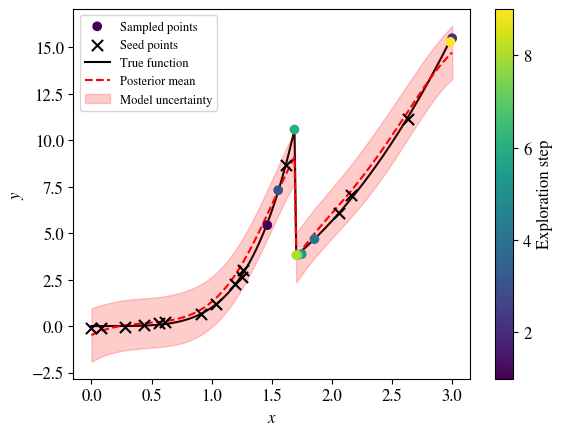

In [21]:
# Plot results
plt.figure(dpi=100)
plt.scatter(X[seed_points:], y[seed_points:], c=jnp.arange(1, len(X[seed_points:])+1),
            cmap='viridis', label="Sampled points", zorder=1)
cbar = plt.colorbar(label="Exploration step")
cbar_ticks = np.arange(2, len(X[seed_points:]) + 1, 2)
cbar.set_ticks(cbar_ticks)
plt.scatter(X[:seed_points], y[:seed_points], marker='x', s=64,
            c='k', label="Seed points", zorder=1)
plt.plot(X_test, truefunc, c='k', label='True function', zorder=0)
plt.plot(X_test, posterior_mean, '--', c='red', label='Posterior mean', zorder=0)

plt.fill_between(X_test, posterior_mean - f_samples.std((0,1)), posterior_mean + f_samples.std((0,1)),
                        color='r', alpha=0.2, label="Model uncertainty", zorder=0)
plt.xlabel("$x$", fontsize=12)
plt.ylabel("$y$", fontsize=12)
plt.legend(fontsize=9)
plt.show()

Even though it required more steps (and each step took longer to converge), it is still able to reconstuct the underlying discontinuous function. Note that the vanilla GP won't be able to do so (you can check it by removing the mean_fn and mean_fn_prior arguments from the GP initialization and rerunning the process).